#  **Homework Problem**

This homework problem involves the autonomous segmentation of nuclei. This task was produced by Kaggle for the [2018 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2018) and instructed researchers to segment a wide range of nuclei across varied conditions. This Colab notebook contains all of the requisite code to complete the segmentation process so feel free to run all of the cells (Ctrl+F9) and visualize the predicted outputs.  Make sure Python3 and a GPU are enabled in "Edit -> Notebook Settings. This notebook is based on [this GitHub repository](https://github.com/kamalkraj/DATA-SCIENCE-BOWL-2018) and implemented the [U-Net architecture](https://arxiv.org/abs/1505.04597), which is a popular architecture for biomedical image segmentation.


<font color='red'>Do not delete the output of the cells when you submit the notebook.</font>



In [ ]:
# ------ No need to change this code, just use it as is -------
import os
# Data download and unzipping
!wget –quiet  https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
!wget –quiet  https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c

if os.path.isdir('stage1_train'):
  !rm -rf 'stage1_train'
  
if os.path.isdir('stage1_test'):
  !rm -rf 'stage1_test'
  
!mkdir stage1_train stage1_test

!unzip -qq stage1_train.zip -d stage1_train/
!unzip -qq stage1_test.zip -d stage1_test/

--2020-11-09 01:31:25--  http://xn--quiet-xu3b/
Resolving xn--quiet-xu3b (xn--quiet-xu3b)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--quiet-xu3b’
--2020-11-09 01:31:25--  https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-11-09 01:31:25--  http://xn--quiet-xu3b/
Resolving xn--quiet-xu3b (xn--quiet-xu3b)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--quiet-xu3b’
--2020-11-09 01:31:25--  https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip
Resolving raw.git

In [ ]:
#***IMPORTANT****
#Run this cell and make sure the timestamp output is before the submission deadline when you submit.
import datetime
from pytz import timezone
tz = timezone('US/Eastern')
d = datetime.datetime.now(tz)
print('Current date and time: ', d)

Current date and time:  2020-11-08 20:31:29.435244-05:00


In [ ]:
# ------ No need to change this code, just use it as is -------
# Downloading and intstalling keras
!pip -q install keras

In [ ]:
# ------ No need to change this code, just use it as is -------
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
%matplotlib inline

# Setting seed for reproducability
seed = 20
random.seed = seed
np.random.seed(seed)
smooth = 0.001
epochs = 50

In [ ]:
# ------ No need to change this code, just use it as is -------
# Data Path
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

In [ ]:
# ------ No need to change this code, just use it as is -------
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [ ]:
# ------ No need to change this code, just use it as is -------
# Function read train images and mask return as nump array
def read_train_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    if os.path.isfile("train_img.npy") and os.path.isfile("train_mask.npy"):
        print("Train file loaded from memory")
        X_train = np.load("train_img.npy")
        Y_train = np.load("train_mask.npy")
        return X_train,Y_train
    a = Progbar(len(train_ids))
    for n, id_ in enumerate(train_ids):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                        preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n+1)
    np.save("train_img",X_train)
    np.save("train_mask",Y_train)
    return X_train,Y_train

In [ ]:
# ------ No need to change this code, just use it as is -------
# Function to read test images and return as numpy array
def read_test_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('\nGetting and resizing test images ... ')
    sys.stdout.flush()
    if os.path.isfile("test_img.npy") and os.path.isfile("test_size.npy"):
        print("Test file loaded from memory")
        X_test = np.load("test_img.npy")
        sizes_test = np.load("test_size.npy")
        return X_test,sizes_test
    b = Progbar(len(test_ids))
    for n, id_ in enumerate(test_ids):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
        b.update(n+1)
    np.save("test_img",X_test)
    np.save("test_size",sizes_test)
    return X_test,sizes_test

In [ ]:
# ------ No need to change this code, just use it as is -------
def get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
# ------ No need to change this code, just use it as is -------
# get train_data
train_img,train_mask = read_train_data()

# get test_data
test_img,test_img_sizes = read_test_data()

Getting and resizing train images and masks ... 
Train file loaded from memory

Getting and resizing test images ... 
Test file loaded from memory


In [ ]:
# ------ No need to change this code, just use it as a function-------
# Metric/loss function
def dice_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:

# TODO: obtain  a model by calling the function get_unet() (~1 line)
model = get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3)
# TODO: Compile the model with binary crossentropy loss (~1 line)
# hint:  dice_coef metric is custom defined. You need to look up how to provide custom metrics to the model.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[dice_coef])
#end of TODO
earlystop = EarlyStopping(monitor='val_dice_coef',patience=5,mode = 'max')

# Fit the first model on training data with 15% validation split

In [ ]:
#TODO: fit the model on training data and store output to variable 'history'. Dont forget to pass the earlystopping callback(~ 1line)
history= model.fit(train_img,train_mask, batch_size= 8, epochs=50, validation_split=0.15, callbacks=[earlystop], shuffle=True) 

Epoch 1/50
72/72 [==============================] - 7s 102ms/step - loss: 0.3197 - dice_coef: 0.3912 - val_loss: 0.1694 - val_dice_coef: 0.6451
Epoch 2/50
72/72 [==============================] - 6s 87ms/step - loss: 0.1505 - dice_coef: 0.6782 - val_loss: 0.1314 - val_dice_coef: 0.7495
Epoch 3/50
72/72 [==============================] - 6s 88ms/step - loss: 0.1164 - dice_coef: 0.7451 - val_loss: 0.1039 - val_dice_coef: 0.8008
Epoch 4/50
72/72 [==============================] - 6s 89ms/step - loss: 0.1001 - dice_coef: 0.7851 - val_loss: 0.1004 - val_dice_coef: 0.8265
Epoch 5/50
72/72 [==============================] - 6s 90ms/step - loss: 0.1063 - dice_coef: 0.7812 - val_loss: 0.0997 - val_dice_coef: 0.8168
Epoch 6/50
72/72 [==============================] - 7s 91ms/step - loss: 0.0971 - dice_coef: 0.7978 - val_loss: 0.0921 - val_dice_coef: 0.8177
Epoch 7/50
72/72 [==============================] - 7s 91ms/step - loss: 0.0889 - dice_coef: 0.8103 - val_loss: 0.0980 - val_dice_coef: 0.823



Plot the training and validation set loss and Dice coefficient metrics for each epoch. It is recommended you make use of the [fit](https://keras.io/models/model/) function.

For help on plotting  metrics and losses go through this [link](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/).

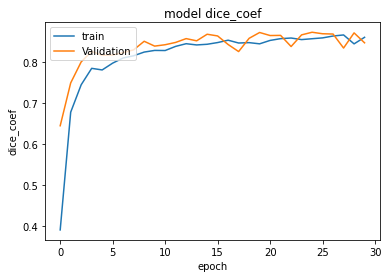

In [ ]:
#TODO: Plot training and validation dice_coef for the model
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()


#end of TODO


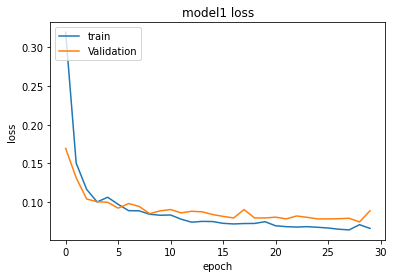

In [ ]:
#TODO plot training and validation loss for model 1
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
#end of TODO

#Run the model on test set and store the output predictions

In [ ]:
#TODO: run the model on the testset (~ 1line)
OP = model.predict(test_img)
#end of TODO
print(OP)

In [ ]:
#lets randomly pick 5 images from test set
#pick 5 random indices between 0 and 64 to plot the correspoding images
randimg = np.random.randint(0,64,5)
#TODO get the test images, model_predictions corresponding to above ids (~ 2 line)
imges_1 = test_img[randimg]
model_X = OP[randimg]
#end of TODO
"""
predicitons has a shape (5,256,256,1). 
To get rid of unnecessary last dimension you need to use np.squeeze to convert shape to (5,256,256).
If the test prediction is not squeezed matplotlib will throw an error.

It only should be performed on the arrays with unnecessary extra dimension.
"""
#TODO reduce the dimension of the predicted array (~ 1lines)
model_X = np.squeeze(model_X)
#end of TODO


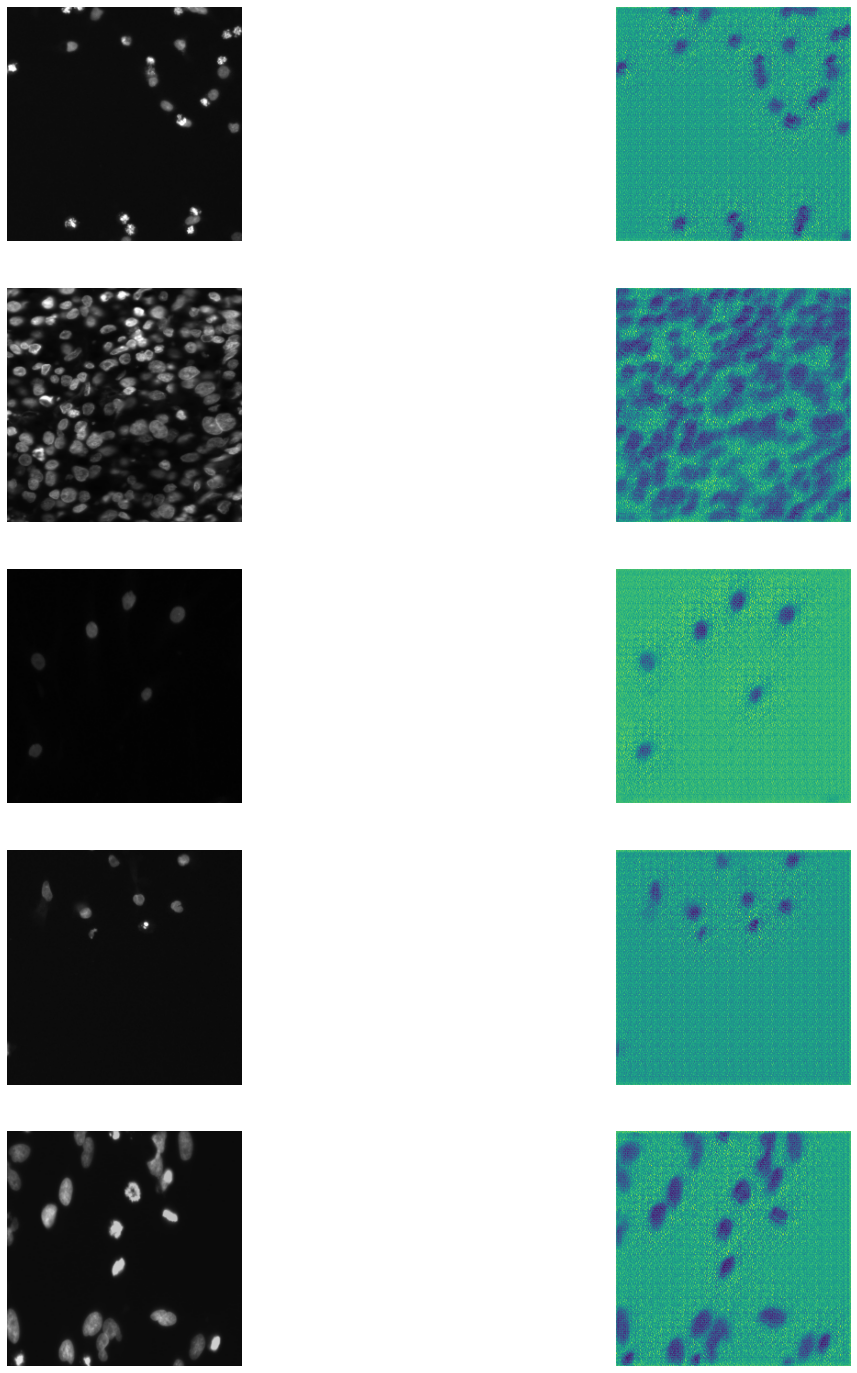

In [ ]:
# TODO: Plot the 5 test images and predictions by the model
# Every row in the plot should contain input test image and its corresponding prediction
fig= plt.figure(figsize=(20,25))
gs= GridSpec(5,2,figure=fig)
for i in range(len(imges_1)):
  ax1= fig.add_subplot(gs[i,0])
  ax1.imshow(imges_1[i])
  ax1.axis('off')
for i in range(len(model_X)):
  ax2= fig.add_subplot(gs[i,1])
  ax2.imshow(model_X[i])
  ax2.axis('off')

#end of TODO